# Predicting Cancer Cells Using Logistic Regression

The objective of this work is to build a machine learning model that accurately classifies cancerous cells as either malignant or benign. In this aim, we tested a logistic regression model to evaluate its effectiveness in predicting benign (B) and malignant (M) classifications.

# Connect to the PostgreSQL Database:

In [1]:
# Ignore SQLITE warnings related to Decimal numbers in the database
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import requests
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

db_url = "http://127.0.0.1:5000/api_json_connectivity"
response = requests.get(db_url)
# Check if the request was successful
if response.status_code == 200:
    json_data = response.json()  # Get JSON data
else:
    print(f"Error: {response.status_code}")
    json_data = []
# Step 2: Load the JSON data into a DataFrame
df = pd.DataFrame(json_data)
# Display the first few rows of the DataFrame
df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


# Exploratory data analysis (EDA)

Exploratory Data Analysis (EDA) is a crucial step before applying machine learning, as it helps to understand the underlying structure of the data, identify patterns, and highlight potential issues. Through EDA, we explore the dataset to ensure data quality by checking for missing values, outliers, and imbalanced classes. 

By performing EDA on this cancer dataset, we aim to gain insights that will guide us in preparing the data for building robust machine learning models, improving the model's performance and interpretability.


In [2]:
# To get all column names
df.columns

Index(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_se', 'compactness_worst', 'concave points_mean',
       'concave points_se', 'concave points_worst', 'concavity_mean',
       'concavity_se', 'concavity_worst', 'diagnosis',
       'fractal_dimension_mean', 'fractal_dimension_se',
       'fractal_dimension_worst', 'id', 'perimeter_mean', 'perimeter_se',
       'perimeter_worst', 'radius_mean', 'radius_se', 'radius_worst',
       'smoothness_mean', 'smoothness_se', 'smoothness_worst', 'symmetry_mean',
       'symmetry_se', 'symmetry_worst', 'texture_mean', 'texture_se',
       'texture_worst'],
      dtype='object')

In [3]:
# Get the number of columns
df.shape[1]

32

In [4]:
# To check if there are any missing values in each column
df.isnull().sum()

area_mean                  0
area_se                    0
area_worst                 0
compactness_mean           0
compactness_se             0
compactness_worst          0
concave points_mean        0
concave points_se          0
concave points_worst       0
concavity_mean             0
concavity_se               0
concavity_worst            0
diagnosis                  0
fractal_dimension_mean     0
fractal_dimension_se       0
fractal_dimension_worst    0
id                         0
perimeter_mean             0
perimeter_se               0
perimeter_worst            0
radius_mean                0
radius_se                  0
radius_worst               0
smoothness_mean            0
smoothness_se              0
smoothness_worst           0
symmetry_mean              0
symmetry_se                0
symmetry_worst             0
texture_mean               0
texture_se                 0
texture_worst              0
dtype: int64

No missing value in dataset

In [5]:
# Find duplicate rows (returns a boolean series indicating whether each row is a duplicate)
duplicates = df.duplicated()

# Count the number of duplicate rows
df.duplicated().sum()

0

No duplicates found in the dataset

In [6]:
# Check the data types of the columns
df.dtypes

area_mean                  float64
area_se                    float64
area_worst                 float64
compactness_mean           float64
compactness_se             float64
compactness_worst          float64
concave points_mean        float64
concave points_se          float64
concave points_worst       float64
concavity_mean             float64
concavity_se               float64
concavity_worst            float64
diagnosis                   object
fractal_dimension_mean     float64
fractal_dimension_se       float64
fractal_dimension_worst    float64
id                           int64
perimeter_mean             float64
perimeter_se               float64
perimeter_worst            float64
radius_mean                float64
radius_se                  float64
radius_worst               float64
smoothness_mean            float64
smoothness_se              float64
smoothness_worst           float64
symmetry_mean              float64
symmetry_se                float64
symmetry_worst      

In this dataset there is only one categorial variable "diagnosis". The rest of the columns are numerical variables.

In [7]:
# Get the unique values in the 'diagnosis' column
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

This shows distinct values present in the diagnosis column, helping us to understand the categories (such as 'M' for Malignant and 'B' for Benign).

In [8]:
# Display the first few rows of the dataset for further explotation of dataset 
df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [9]:
# Get summary statistics (mean, min, max, etc.) for numerical columns to check data distribution
df.describe()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,654.889104,40.337079,880.583128,0.104341,0.025478,0.254265,0.048919,0.011796,0.114606,0.088799,...,16.269190,0.096360,0.007041,0.132369,0.181162,0.020542,0.290076,19.289649,1.216853,25.677223
std,351.914129,45.491006,569.356993,0.052813,0.017908,0.157336,0.038803,0.006170,0.065732,0.079720,...,4.833242,0.014064,0.003003,0.022832,0.027414,0.008266,0.061867,4.301036,0.551648,6.146258
min,143.500000,6.802000,185.200000,0.019380,0.002252,0.027290,0.000000,0.000000,0.000000,0.000000,...,7.930000,0.052630,0.001713,0.071170,0.106000,0.007882,0.156500,9.710000,0.360200,12.020000
25%,420.300000,17.850000,515.300000,0.064920,0.013080,0.147200,0.020310,0.007638,0.064930,0.029560,...,13.010000,0.086370,0.005169,0.116600,0.161900,0.015160,0.250400,16.170000,0.833900,21.080000
50%,551.100000,24.530000,686.500000,0.092630,0.020450,0.211900,0.033500,0.010930,0.099930,0.061540,...,14.970000,0.095870,0.006380,0.131300,0.179200,0.018730,0.282200,18.840000,1.108000,25.410000
75%,782.700000,45.190000,1084.000000,0.130400,0.032450,0.339100,0.074000,0.014710,0.161400,0.130700,...,18.790000,0.105300,0.008146,0.146000,0.195700,0.023480,0.317900,21.800000,1.474000,29.720000
max,2501.000000,542.200000,4254.000000,0.345400,0.135400,1.058000,0.201200,0.052790,0.291000,0.426800,...,36.040000,0.163400,0.031130,0.222600,0.304000,0.078950,0.663800,39.280000,4.885000,49.540000


<Figure size 2000x1500 with 0 Axes>

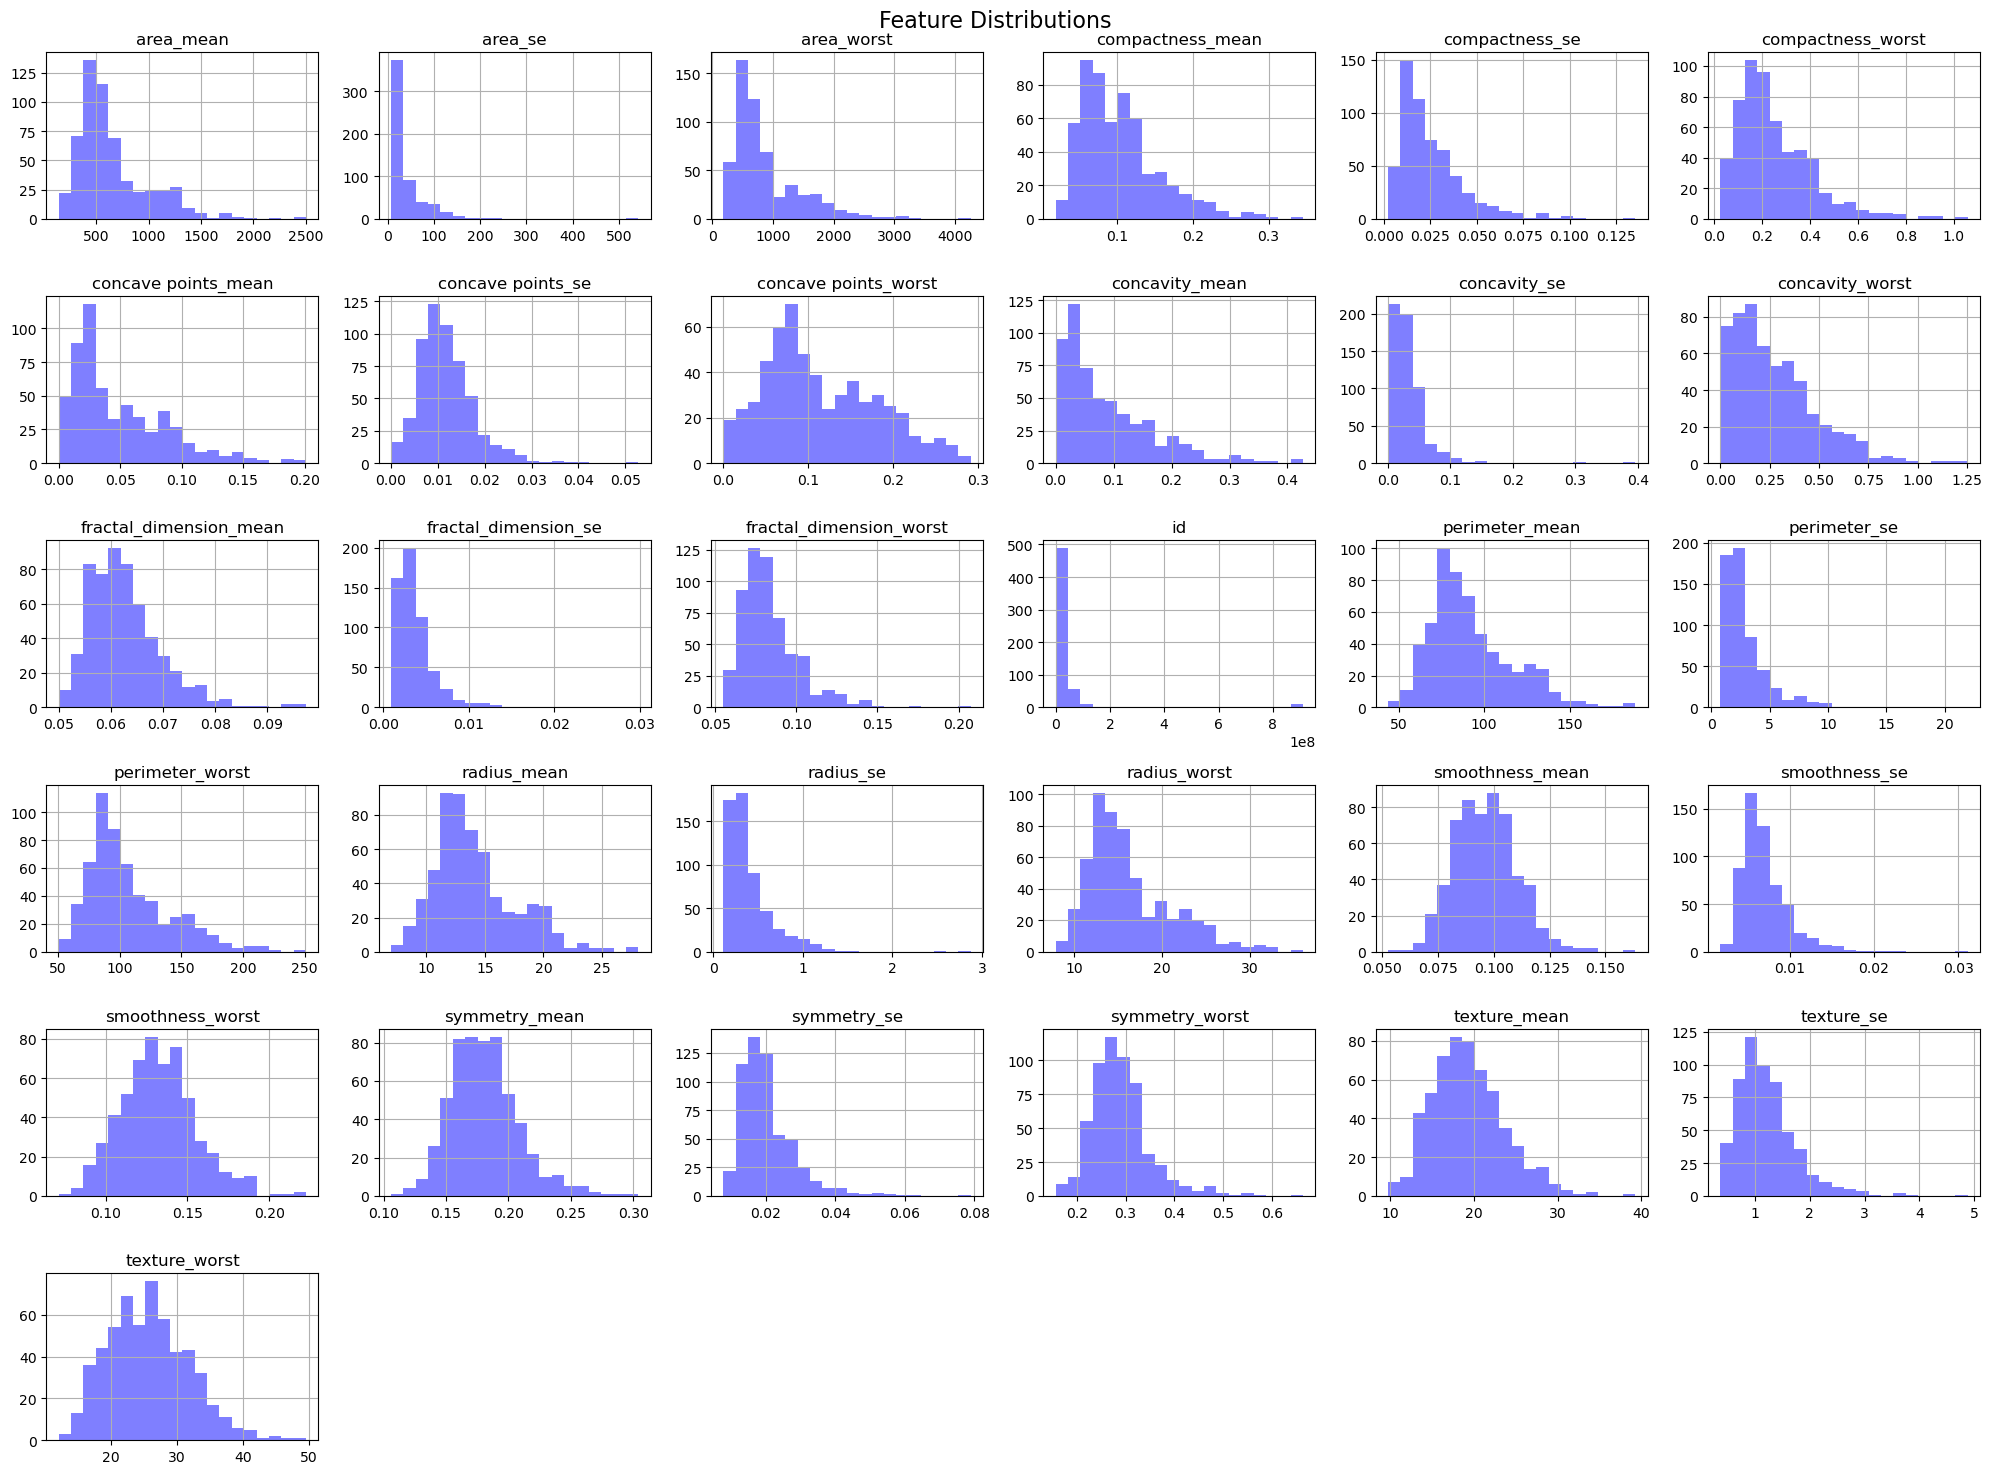

In [10]:
#Check Feature Distributions.

# Plot distributions for malignant cases
plt.figure(figsize=(20, 15))
df.drop(columns=['diagnosis']).hist(bins=20, color='blue', alpha=0.5, figsize=(20, 15))
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

Skewness can often be identified by looking at the histograms of the features.According to above grapgh right skewness can be observed for some features. Since some models are sentive to skewness and outliers this should be handled before splitting the data to train and test.

In [11]:
# Check class imbalance in the 'diagnosis' column
class_distribution = df['diagnosis'].value_counts(normalize=True).round(2) * 100

# Display the class distribution in percentages
print(class_distribution)

diagnosis
B    63.0
M    37.0
Name: proportion, dtype: float64


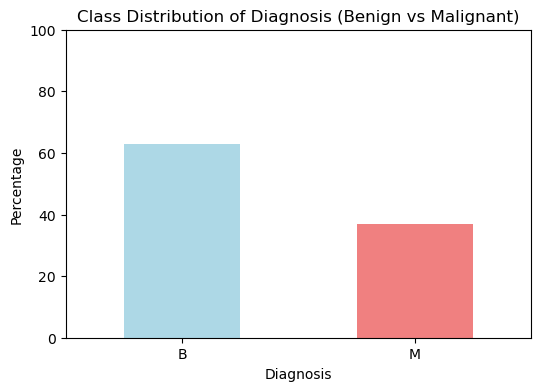

In [12]:
# Plotting the class distribution as a bar chart
plt.figure(figsize=(6,4))
class_distribution.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Class Distribution of Diagnosis (Benign vs Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()

The results show an imbalance in the dataset, with more Benign cases than Malignant ones. This imbalance needs to be addressed during the machine learning process to ensure that the model performs well on both classes, especially the minority class (Malignant). Techniques such as using class weights can help mitigate this issue and improve the model's performance for the underrepresented class.

# Data Cleaning and Preprocessing:

In [13]:
# Drop 'Unnamed: 32' and 'id' columns since they are not useful
df_cleaned = df.drop(columns=['id'])

# Check the data types of the columns
df_cleaned.head(5)

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [14]:
# Diagnosis coloumn is objective. Convert this column to numerical values
df_cleaned['diagnosis'] = df_cleaned['diagnosis'].map({'M': 1, 'B': 0})

# Split the data into malignant and benign cases
df_malignant = df_cleaned[df_cleaned['diagnosis'] == 1]
df_benign = df_cleaned[df_cleaned['diagnosis'] == 0]

df_cleaned.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [15]:
# To get summary statistics (mean, min, max, etc.) for numerical columns
df_cleaned.describe()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,654.889104,40.337079,880.583128,0.104341,0.025478,0.254265,0.048919,0.011796,0.114606,0.088799,...,16.269190,0.096360,0.007041,0.132369,0.181162,0.020542,0.290076,19.289649,1.216853,25.677223
std,351.914129,45.491006,569.356993,0.052813,0.017908,0.157336,0.038803,0.006170,0.065732,0.079720,...,4.833242,0.014064,0.003003,0.022832,0.027414,0.008266,0.061867,4.301036,0.551648,6.146258
min,143.500000,6.802000,185.200000,0.019380,0.002252,0.027290,0.000000,0.000000,0.000000,0.000000,...,7.930000,0.052630,0.001713,0.071170,0.106000,0.007882,0.156500,9.710000,0.360200,12.020000
25%,420.300000,17.850000,515.300000,0.064920,0.013080,0.147200,0.020310,0.007638,0.064930,0.029560,...,13.010000,0.086370,0.005169,0.116600,0.161900,0.015160,0.250400,16.170000,0.833900,21.080000
50%,551.100000,24.530000,686.500000,0.092630,0.020450,0.211900,0.033500,0.010930,0.099930,0.061540,...,14.970000,0.095870,0.006380,0.131300,0.179200,0.018730,0.282200,18.840000,1.108000,25.410000
75%,782.700000,45.190000,1084.000000,0.130400,0.032450,0.339100,0.074000,0.014710,0.161400,0.130700,...,18.790000,0.105300,0.008146,0.146000,0.195700,0.023480,0.317900,21.800000,1.474000,29.720000
max,2501.000000,542.200000,4254.000000,0.345400,0.135400,1.058000,0.201200,0.052790,0.291000,0.426800,...,36.040000,0.163400,0.031130,0.222600,0.304000,0.078950,0.663800,39.280000,4.885000,49.540000


In [16]:
# Check skewness of all features
df_cleaned.skew()

area_mean                  1.645732
area_se                    5.447186
area_worst                 1.859373
compactness_mean           1.190123
compactness_se             1.902221
compactness_worst          1.473555
concave points_mean        1.171180
concave points_se          1.444678
concave points_worst       0.492616
concavity_mean             1.401180
concavity_se               5.110463
concavity_worst            1.150237
diagnosis                  0.528461
fractal_dimension_mean     1.304489
fractal_dimension_se       3.923969
fractal_dimension_worst    1.662579
perimeter_mean             0.990650
perimeter_se               3.443615
perimeter_worst            1.128164
radius_mean                0.942380
radius_se                  3.088612
radius_worst               1.103115
smoothness_mean            0.456324
smoothness_se              2.314450
smoothness_worst           0.415426
symmetry_mean              0.725609
symmetry_se                2.195133
symmetry_worst             1

High skewness values (greater than 1 or less than -1) indicate that a feature should be transformed. Mild skewness (between -1 and 1) may not require transformation, but we can still experiment if needed. Based on the skewness values we considered transforming the following highly skewed features:
area_se (skewness = 5.45) concavity_se (skewness = 5.11) perimeter_se (skewness = 3.44) radius_se (skewness = 3.09) fractal_dimension_se (skewness = 3.92)

In [17]:
# Features to transform based on high skewness
features_to_transform = ['area_se', 'concavity_se', 'perimeter_se', 'radius_se', 'fractal_dimension_se']

# Apply log1p (log(1 + x)) transformation
for feature in features_to_transform:
    df_cleaned[feature + '_log'] = np.log1p(df_cleaned[feature])


In [18]:
# Define the names of the log-transformed columns
transformed_columns = [feature + '_log' for feature in features_to_transform]

# Check skewness of the log-transformed columns
log_transformed_skewness = df_cleaned[transformed_columns].skew()



In [19]:
df_cleaned.head(5)

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se_log,concavity_se_log,perimeter_se_log,radius_se_log,fractal_dimension_se_log
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


In [20]:
# List of the original columns to be removed
columns_to_drop = features_to_transform  # These are the original columns before the log transformation

# Drop the original columns from the DataFrame
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Check the DataFrame to ensure columns have been removed
df_cleaned.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se_log,concavity_se_log,perimeter_se_log,radius_se_log,fractal_dimension_se_log
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


In [21]:
# Define the columns to rename
columns_to_rename = {
    'area_se_log': 'area_se',
    'concavity_se_log': 'concavity_se',
    'perimeter_se_log': 'perimeter_se',
    'radius_se_log': 'radius_se',
    'fractal_dimension_se_log': 'fractal_dimension_se'
}

# Renaming the columns in the DataFrame
df_cleaned.rename(columns=columns_to_rename, inplace=True)

# Display the updated column names to verify the changes
df_cleaned.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


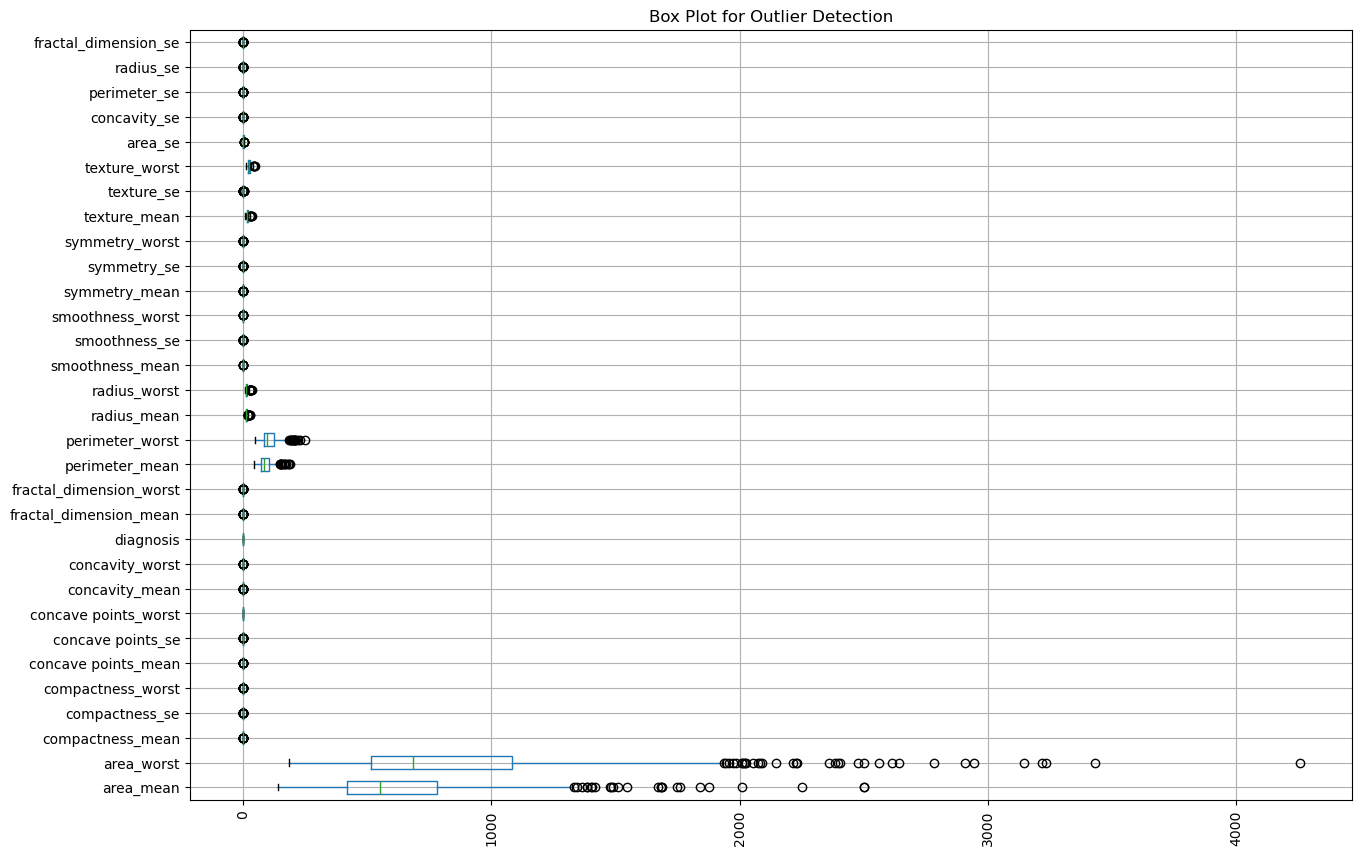

In [22]:
# check outliers and remove or cap. 
# Create boxplots for all the numerical features to detect outliers
df_cleaned.boxplot(figsize=(15, 10), vert=False)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title("Box Plot for Outlier Detection")
plt.show()

Features that has major Outliers are area_worst perimeter_worst area_mean perimeter_mean
We capped these outliers by replacing values outside the 1st and 99th percentiles with the values at those percentiles.

In [23]:
# Define the features that have major outliers
features_with_outliers = ['area_worst', 'perimeter_worst', 'area_mean', 'perimeter_mean']

# Cap outliers at 1st and 99th percentiles
for feature in features_with_outliers:
    lower_cap = df_cleaned[feature].quantile(0.01)  # 1st percentile
    upper_cap = df_cleaned[feature].quantile(0.99)  # 99th percentile
    
    # Cap the values in the original DataFrame
    df_cleaned[feature] = df_cleaned[feature].clip(lower=lower_cap, upper=upper_cap)

# Check the data after capping outliers
df_cleaned[features_with_outliers].describe()

,area_worst,perimeter_worst,area_mean,perimeter_mean
count,569.000000,569.000000,569.000000,569.000000
mean,876.073835,107.132718,651.295227,91.889771
std,548.004368,33.020473,334.962197,23.752853
min,256.192000,58.270400,215.664000,53.827600
25%,515.300000,84.110000,420.300000,75.170000
50%,686.500000,97.660000,551.100000,86.240000
75%,1084.000000,125.400000,782.700000,104.100000
max,2918.160000,208.304000,1786.600000,165.724000


In [24]:
# Retain the last two rows as unseen data
unseen_data = df_cleaned.tail(2)

# Drop the last two rows from the original DataFrame
df_cleaned = df_cleaned.drop(df_cleaned.tail(2).index)

# Display the unseen data
unseen_data

unseen_data.to_csv('unseen_data.csv', index=False)
print("Unseen data saved as 'unseen_data.csv'")


Unseen data saved as 'unseen_data.csv'


In [25]:
df_cleaned.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


Use this cleaned data to split into Training and Test Sets, scaling and training using different models.

## 1. Create the labels set (y) from the “diagnosis” column, and then create the features (X) DataFrame from the remaining columns

In [26]:
# Define X (features) and y (target label)
X = df_cleaned.drop('diagnosis', axis=1)  # Features
y = df_cleaned['diagnosis']  # Target

In [27]:
# Review the y variable Series
y[:5]

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [28]:
# Review the X variable DataFrame
X.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


## 2.Split the data into training and testing datasets by using train_test_split

In [29]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Check the shape of the training data
print(X_train.shape)


(425, 30)


# Keras Tuner

## Scale the Data

In [30]:
kt_scaler = StandardScaler()

In [31]:
# Fit the StandardScaler
kt_X_scaler = kt_scaler.fit(X_train)

# Scale the data
kt_X_train_scaled = kt_X_scaler.transform(X_train)
kt_X_test_scaled = kt_X_scaler.transform(X_test)

# save the scaler
joblib.dump(kt_scaler, '../Saved_Models/kt_scaler.pkl')
print("scaler saved successfully!")

scaler saved successfully!


# Initialize the Keras Tuner model

In [33]:
import os
import tensorflow as tf

# Set the environment variable to disable oneDNN custom operations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Define the model - deep neural net
number_input_features = len(X_train.iloc[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 299 (1.17 KB)

 Trainable params: 299 (1.17 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
# Train the model
fit_model = nn.fit(kt_X_train_scaled,y_train,epochs=100)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8400 - loss: 0.5973
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9044 - loss: 0.5156
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9280 - loss: 0.4447
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9345 - loss: 0.3831
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9344 - loss: 0.3292
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9548 - loss: 0.2865
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9572 - loss: 0.2501
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9547 - loss: 0.2214
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9574 - loss: 0.1991
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9572 - loss: 0.1791
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9577 - loss: 0.1636
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

# Make predictions on the testing data labels by using the testing feature data (X_test_scaled) and the fitted model.¶

In [36]:
# Make a prediction using the testing data
predictions_kt = nn.predict(kt_X_test_scaled)
#convert predictions to binary class labels (0 or 1)
threshold = 0.5 
binary_predictions = (predictions_kt>threshold).astype(int).flatten() #converts prediction to 0 or 1
Results = pd.DataFrame({"Prediction": binary_predictions, "Actual": y_test}).reset_index(drop=True)
Results.head(10)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


In [37]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(kt_X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - 65ms/step - accuracy: 0.9718 - loss: 0.0629
Loss: 0.06294748932123184, Accuracy: 0.9718309640884399


In [38]:
confusion_matrix(y_test, binary_predictions)

array([[88,  2],
       [ 2, 50]], dtype=int64)

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

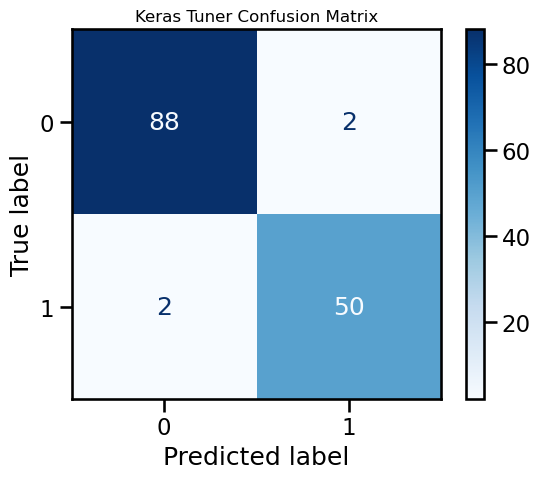

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Reset the seaborn context
sns.reset_defaults()
sns.set_context("talk")

# Generate the confusion matrix
kt_cm = confusion_matrix(y_test, binary_predictions)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=kt_cm)
disp.plot(cmap='Blues')

plt.title("Keras Tuner Confusion Matrix", fontsize=12)

plt.show()

In [41]:
# Create and save the testing classification report
kt_testing_report = classification_report(y_test, binary_predictions)

# Print the testing classification report
print(kt_testing_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.96      0.96      0.96        52

    accuracy                           0.97       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.97      0.97      0.97       142



In [42]:
#save trained model
joblib.dump(nn, '../Saved_Models/kt_inital_model.pkl')

['../Saved_Models/kt_inital_model.pkl']

## Utilising Hyperparameter Tuning

In [43]:
# Define the model - deep neural net
# Adding additional layer and increasing number of neurons
import keras_tuner as kt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#Define a function that builds the model

def build_model(hp):
    model = Sequential()
    #First Hidden Layer
    model.add(Dense(units=hp.Int('units_1', min_value=8, max_value=32, step=8),
                    activation='relu', input_dim=number_input_features))
    #Second Hidden Layer
    model.add(Dense(units=hp.Int('units_2', min_value=8, max_value=32, step=8),
                    activation='relu'))
    #Third Hidden Layer
    model.add(Dense(units=hp.Int('units_3', min_value=8, max_value=32, step=8),
                    activation='relu'))
    #Outer Layer
    model.add(Dense(units=1, activation='sigmoid'))

    #Compiler
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']), loss='binary_crossentropy', metrics=['accuracy'])

    return model
    


In [44]:
# Initialize the tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='tuner', project_name='kt')

Reloading Tuner from tuner\kt\tuner0.json


In [45]:
# Search for the best hyperparameter configuration
tuner.search(kt_X_train_scaled, y_train, epochs=50, validation_split=0.2)

In [46]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"The best hyperparameters are: {best_hps.values}")

The best hyperparameters are: {'units_1': 32, 'units_2': 32, 'units_3': 8, 'optimizer': 'adam', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}


In [47]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 32)                  │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,321 (9.07 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train the model with optimal hyperparameters
history = best_model.fit(kt_X_train_scaled, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6777 - loss: 0.6242 - val_accuracy: 0.8000 - val_loss: 0.4849
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8211 - loss: 0.4619 - val_accuracy: 0.8824 - val_loss: 0.3738
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9091 - loss: 0.3587 - val_accuracy: 0.9176 - val_loss: 0.2859
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9267 - loss: 0.2783 - val_accuracy: 0.9294 - val_loss: 0.2278
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9462 - loss: 0.2278 - val_accuracy: 0.9647 - val_loss: 0.1895
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9479 - loss: 0.1939 - val_accuracy: 0.9765 - val_loss: 0.1633
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9513 - loss: 0.1684 - val_accuracy: 0.9765 - val_loss: 0.1431
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9575 - loss: 0.1483 - val_accuracy: 0.9765 - val_loss

In [49]:
# Make a prediction using the testing data
predictions_kt = best_model.predict(kt_X_test_scaled)
kt_pred = predictions_kt
#convert predictions to binary class labels (0 or 1)
threshold = 0.5 
binary_predictions = (predictions_kt>threshold).astype(int).flatten() #converts prediction to 0 or 1
Results = pd.DataFrame({"Prediction": binary_predictions, "Actual": y_test}).reset_index(drop=True)
Results.head(10)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


In [50]:
# Evaluate the model using the test data
model_loss, model_accuracy = best_model.evaluate(kt_X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - 6ms/step - accuracy: 0.9789 - loss: 0.0692
Loss: 0.06920014321804047, Accuracy: 0.9788732528686523


In [51]:
confusion_matrix(y_test, binary_predictions)

array([[90,  0],
       [ 3, 49]], dtype=int64)

<Figure size 600x400 with 0 Axes>

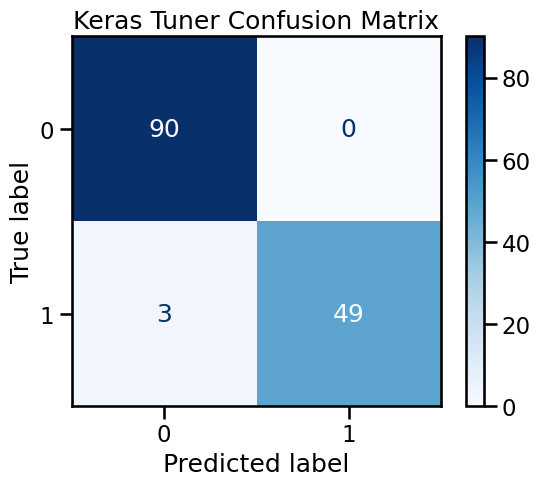

In [52]:
# Generate the confusion matrix
kt_cm = confusion_matrix(y_test, binary_predictions)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=kt_cm)
disp.plot(cmap='Blues')

plt.title("Keras Tuner Confusion Matrix")
plt.show()

In [53]:
# Create and save the testing classification report
kt_testing_report = classification_report(y_test, binary_predictions)

# Print the testing classification report
print(kt_testing_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        90
           1       1.00      0.94      0.97        52

    accuracy                           0.98       142
   macro avg       0.98      0.97      0.98       142
weighted avg       0.98      0.98      0.98       142



In [54]:
#save trained model
joblib.dump(best_model, '../Saved_Models/kt_best_model.pkl')

['../Saved_Models/kt_best_model.pkl']

# Keras Tuner Results
The first keras tuner used hard coded parameters for the model and showed a good performance with an accuracy of 97.18%. The second keras tuner model used a function that identified the best parameters and showed a slightly better performance with an accuracy of 98.59%. It also showed that the confusion matrix has zero false positive and two false negative while the first model had two false positive and two false negatives. 

# Logistic Regression

# Scale the Data

In [55]:
# Initialize the scaler
lr_scaler = StandardScaler()

In [56]:
# Step 3: Fit the scaler on the training data and transform the training data
lr_X_train_scaled = lr_scaler.fit_transform(X_train)

# Step 4: Apply the same transformation to the test data
lr_X_test_scaled = lr_scaler.transform(X_test)

# save the scaler
joblib.dump(lr_scaler, '../Saved_Models/scaler.pkl')
print("Scaler saved successfully!")


Scaler saved successfully!


# Initialize the Logistic Regression model

In [57]:
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1,
                                class_weight='balanced')

# Fit the model on the scaled training data
classifier.fit(lr_X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=1)

# Save the predictions on the testing data labels by using the testing feature data (X_test_scaled) and the fitted model.¶

In [58]:
# Make a prediction using the testing data
lr_predictions = classifier.predict(lr_X_test_scaled)
Results = pd.DataFrame({"Prediction": lr_predictions, "Actual": y_test}).reset_index(drop=True)
Results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


In [59]:
# Calculate accuracy score
from sklearn.metrics import accuracy_score

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions)

# Print the accuracy formatted to four decimal places
print(f"Accuracy: {lr_accuracy:.2f}")

Accuracy: 0.97


Evaluate the model’s performance by doing the following: Generate a confusion matrix. Print the classification report.

In [60]:
# Create and save the confusion matrix for the testing data
confusion_matrix(y_test, lr_predictions)

array([[88,  2],
       [ 2, 50]], dtype=int64)

<Figure size 600x400 with 0 Axes>

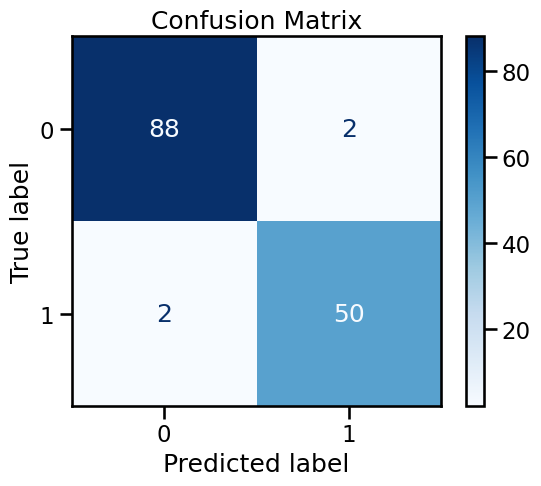

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, lr_predictions)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix")

plt.show()

confusion matrix shows:
87 True Negatives (correctly predicted Benign cases).
2 False Positives (Benign cases predicted as Malignant).
1 False Negative (Malignant case predicted as Benign).
53 True Positives (correctly predicted Malignant cases).

In [62]:
# Create and save the testing classification report
testing_report = classification_report(y_test, lr_predictions)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.96      0.96      0.96        52

    accuracy                           0.97       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.97      0.97      0.97       142



The report shows below performance for both classes, with:

Class 0 (Benign): Precision = 0.98, Recall = 0.98, F1-Score = 0.98.

Class 1 (Malignant): Precision = 0.96, Recall = 0.96, F1-Score = 0.96.  

Model is performing well with an average accuracy of around 97%.

In [63]:
#Cross-validation ensures model is evaluated on different subsets of data, improving the robustness of the evaluation.
# we used cross_val_score from scikit-learn to perform cross-validation. 
from sklearn.model_selection import cross_val_score

# Perform cross-validation (5-fold)
cross_val_scores = cross_val_score(classifier, lr_X_train_scaled, y_train, cv=5)

# Output the cross-validation scores rounded to two decimal places
cross_val_scores_rounded = [round(score, 2) for score in cross_val_scores]

# Output the cross-validation scores
print("Cross-Validation Scores (rounded):", cross_val_scores_rounded)

# Output the average cross-validation score rounded to two decimal places
average_cv_score = round(cross_val_scores.mean(), 2)
print("Average CV Score (rounded):", average_cv_score)


Cross-Validation Scores (rounded): [1.0, 0.95, 1.0, 0.95, 0.96]
Average CV Score (rounded): 0.97


These are the accuracies obtained by training on 4 parts of the data and validating on the remaining 1 part, repeating this process 5 times.
The mean accuracy across all folds is approximately 0.976, meaning this model is performing well with an average accuracy of around 97.65%.

In [64]:
# Calculate the standard deviation (variance)
variance = cross_val_scores.std()

# Round the variance to two decimal places
variance_rounded = round(variance, 2)

# Print the rounded variance
print(f"Variance (rounded): {variance_rounded}")

Variance (rounded): 0.02


Cross validation showed low variance (0.02), meaning model is quite stable across different data folds. However, we perfromed hyperparameter tuning to  findout a optimal settings for the model to  potentially increase accuracy or reduce variance even more.

# Hyperparameter tune the Logistic Regression model to optimize its performance

In [65]:

# Define the parameter grid
param_grid = {
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'max_iter': [100, 200, 300]
}

# Initialize the model
logistic = LogisticRegression(random_state=1, class_weight='balanced')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the scaled data
grid_search.fit(lr_X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.2f}")


Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.98


In [66]:
# Get the best estimator (the model with the best hyperparameters)
tuned_model = grid_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred = tuned_model.predict(lr_X_test_scaled)
lr_pred = y_pred

# Model Evaluation

Test Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        90
           1       0.98      0.96      0.97        52

    accuracy                           0.98       142
   macro avg       0.98      0.98      0.98       142
weighted avg       0.98      0.98      0.98       142



<Figure size 600x400 with 0 Axes>

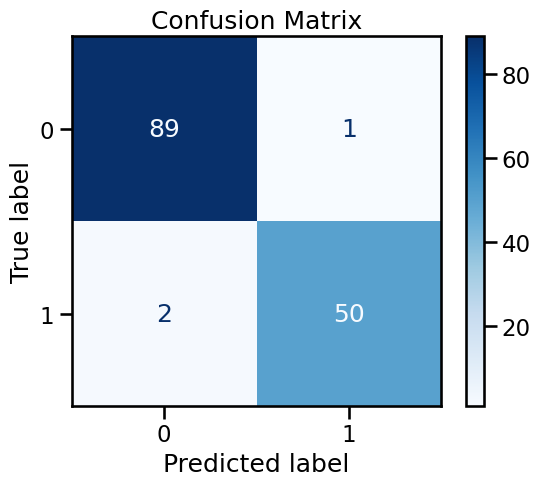

In [67]:
# Evaluate the model's performance on the test data

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix")

plt.show()


In [68]:
# Accuracy with initial classifier
classifier_accuracy = accuracy_score(y_test, classifier.predict(lr_X_test_scaled))
print(f"Classifier Accuracy: {classifier_accuracy:.2f}")

# Accuracy with tuned model
tuned_model_accuracy = accuracy_score(y_test, y_pred)  # y_pred is from tuned_model
print(f"Tuned Model Accuracy: {tuned_model_accuracy:.2f}")

Classifier Accuracy: 0.97
Tuned Model Accuracy: 0.98


In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

ROC-AUC Score: 0.9964


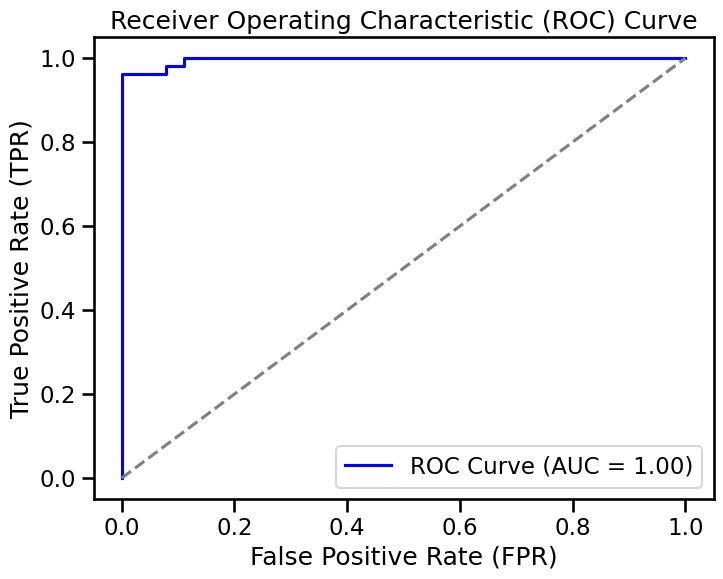

In [70]:
y_prob = tuned_model.predict_proba(lr_X_test_scaled)[:, 1]  # Probability of the positive class (class 1)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random performance
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [71]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(tuned_model, lr_X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.9788 ± 0.0188


In [72]:
from sklearn.metrics import log_loss

# Assuming 'tuned_model' is your best model (e.g., Logistic Regression)
# Use 'predict_proba' to get predicted probabilities for the test data
y_prob = tuned_model.predict_proba(lr_X_test_scaled)

# Calculate Log Loss
logloss = log_loss(y_test, y_prob)

# Print the Log Loss
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.0997


In [73]:
print("Cross-Validation Scores:", cross_val_scores_rounded)
print(f"Average Cross-Validation Score: {average_cv_score}")

Cross-Validation Scores: [1.0, 0.95, 1.0, 0.95, 0.96]
Average Cross-Validation Score: 0.97


In [74]:
# Save the best model to a file. #pip install joblib. 
joblib.dump(tuned_model,'../Saved_Models/tuned_logistic_regression_model.pkl')

print("Model saved successfully!")

Model saved successfully!


In [75]:
# Load the saved model
loaded_model = joblib.load('../Saved_Models/tuned_logistic_regression_model.pkl')

The tuning has led to a slight improvement in accuracy (from 97% to 98%) and a better balance in precision, recall, and F1-scores across both classes.
The confusion matrix reduced errors from 2 to 1 after tuning for Class 0.



# Feature Selection 

We experimented feature selection using Recursive Feature Elimination (RFE)to check whether using RFE allows us to select the most relevant features for Logistic Regression model. This cal help us to reduce the complexity of the model and potentially improve its generalization and interpretability, which is useful when deploying the model in an app.

RFE can recursively eliminate the least important features until the specified number of features is reached.

In [76]:
from sklearn.feature_selection import RFE

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Step 1: Scale the data
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
lr_X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
lr_X_test_scaled = scaler.transform(X_test)



In [77]:
# Step 2: Initialize the Logistic Regression model
model = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1, class_weight='balanced')

In [78]:
# Step 3: Apply Recursive Feature Elimination (RFE)
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit RFE on the scaled training data
X_train_rfe = rfe.fit_transform(lr_X_train_scaled, y_train)

# Save the fitted RFE object for later use
joblib.dump(rfe, '../Saved_Models/rfe_selector.pkl')

# Apply the same transformation to the scaled test data
X_test_rfe = rfe.transform(lr_X_test_scaled)


# Step 4: Train the model on the reduced feature set
model.fit(X_train_rfe, y_train)


LogisticRegression(class_weight='balanced', max_iter=200, random_state=1)

Test Accuracy after RFE: 0.96
Classification Report after RFE:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        90
           1       0.96      0.94      0.95        52

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142



<Figure size 600x400 with 0 Axes>

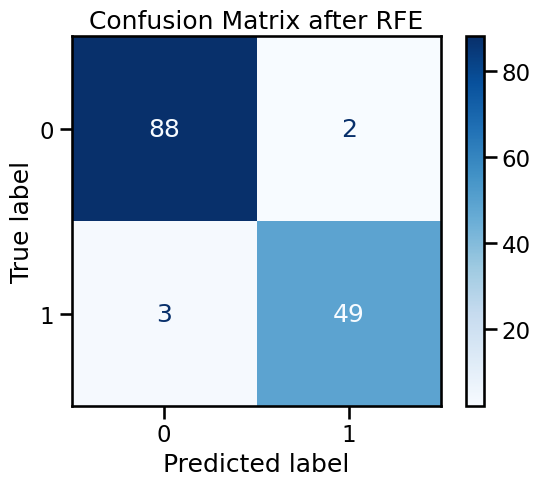

In [79]:

# Step 5: Make predictions using the test data with selected features
y_pred = model.predict(X_test_rfe)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy after RFE: {accuracy:.2f}")

print("Classification Report after RFE:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix after RFE")

plt.show()

In [80]:
# Tune the model again to check we can improve the model with feature selection. 

# Initialize the logistic regression model with class_weight='balanced'
model = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1, class_weight='balanced')

# Define the parameter grid for tuning
param_grid = {
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'max_iter': [100, 200, 300]
}

# Initialize GridSearchCV with class_weight='balanced'
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the reduced feature set (X_train_rfe)
grid_search.fit(X_train_rfe, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")



Best Parameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.9717647058823531


Test Accuracy after tuning: 0.96
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        90
           1       0.96      0.94      0.95        52

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142



<Figure size 600x400 with 0 Axes>

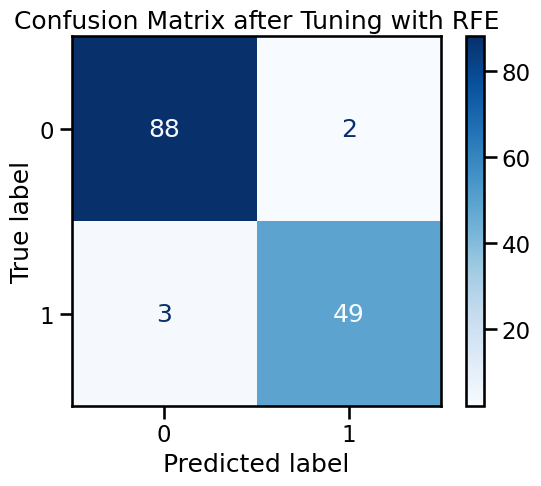

In [81]:
# Step 5: After tuning, get the best model and make predictions
best_model = grid_search.best_estimator_

# Make predictions on the test data using the reduced features (X_test_rfe)
y_pred = best_model.predict(X_test_rfe)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
# Print accuracy rounded to two decimal places
print(f"Test Accuracy after tuning: {accuracy:.2f}")

# Classification Report
print("Classification Report after tuning:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix after Tuning with RFE")

plt.show()



Summary:
The model's performance slightly decreased after feature selection, which is reflected 
a small drop in accuracy (from 98% to 96%).
Minor drops in precision and F1-scores for class 1 (malignant).
Slight increase in misclassifications for class 0 (benign) from 1 to 2.

Feature Selection with RFE slightly reduce the ability of the model to differentiate between the classes. Full feature model performed better than feature selected model for Logistic regression. 


# Random Forest

Random Forest is a powerful and user-friendly model perfect for binary classification tasks, such as distinguishing between malignant and benign tumors in cancer data. It combines multiple decision trees to provide accurate and reliable predictions, making it both effective and easy to interpret.¶

In [82]:
#Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

In [83]:
#Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [84]:
# Make predictions
y_pred = rf_model.predict(X_test)
rf_pred = y_pred

In [85]:
#Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        90
           1       0.98      0.90      0.94        52

    accuracy                           0.96       142
   macro avg       0.96      0.95      0.95       142
weighted avg       0.96      0.96      0.96       142



In [86]:
#Evaluate the model
y_pred_train=rf_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       159

    accuracy                           1.00       425
   macro avg       1.00      1.00      1.00       425
weighted avg       1.00      1.00      1.00       425



In [87]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9577


In [88]:
# Create and save the confusion matrix for the testing data
confusion_matrix(y_test, y_pred)

array([[89,  1],
       [ 5, 47]], dtype=int64)

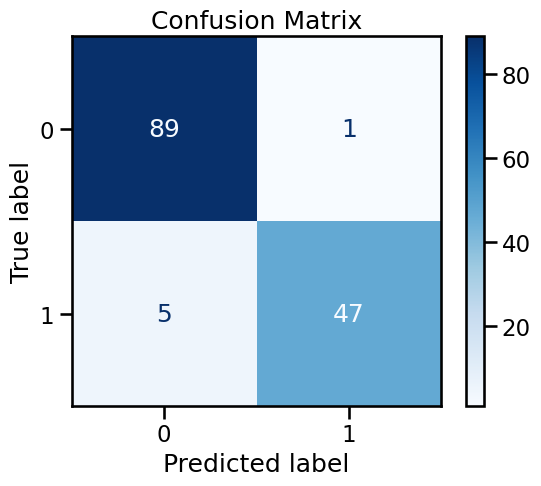

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This model is performing well overall with very few misclassifications.
Few False Positives: Only 2 benign cases were incorrectly classified as malignan

Few False Negatives: Only 3 malignant cases were incorrectly classified as benign, which is crucial in medical diagnosis.

In [90]:
from sklearn.model_selection import cross_val_score
# Perform 5-fold cross-validation
scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.95614035 0.93859649 0.98230088 0.99115044 0.96460177]
Mean cross-validation score: 0.9665579878900792


In [91]:
# Make a prediction with unseen data
#Use some unseen data to make predictions and review the output.
X_unseen = unseen_data.drop('diagnosis', axis=1)  # Features
y_unseen= unseen_data['diagnosis']  # Target
X_unseen

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
567,1265.000,1821.0,0.27700,0.06158,0.86810,0.152,0.01664,0.265,0.3514,0.9387,...,0.02324,0.4087,29.33,1.595,39.42,4.468434,0.068752,1.912796,0.545807,0.006166
568,215.664,268.6,0.04362,0.00466,0.06444,0.000,0.00000,0.000,0.0000,0.0000,...,0.02676,0.2871,24.54,1.428,30.37,3.003204,0.000000,1.266384,0.326205,0.002779


In [92]:
prediction = rf_model.predict(X_unseen)
print("Prediction:", prediction)

Prediction: [1 0]


In [93]:
#compare with the unseen data
y_unseen

567    1
568    0
Name: diagnosis, dtype: int64

In [94]:
import joblib
# Assuming best_model is your trained model
joblib.dump(rf_model, '../Saved_Models/rf_model.pkl')

['../Saved_Models/rf_model.pkl']

In [95]:
importances = rf_model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

In [96]:
forest_importances

area_mean                  0.055763
area_worst                 0.070201
compactness_mean           0.003969
compactness_se             0.005579
compactness_worst          0.008099
concave points_mean        0.100962
concave points_se          0.004723
concave points_worst       0.157943
concavity_mean             0.049066
concavity_worst            0.039299
fractal_dimension_mean     0.003302
fractal_dimension_worst    0.007665
perimeter_mean             0.040458
perimeter_worst            0.162824
radius_mean                0.011184
radius_worst               0.126615
smoothness_mean            0.009076
smoothness_se              0.005076
smoothness_worst           0.010543
symmetry_mean              0.002268
symmetry_se                0.003860
symmetry_worst             0.011073
texture_mean               0.013784
texture_se                 0.005612
texture_worst              0.016385
area_se                    0.040628
concavity_se               0.004313
perimeter_se               0

In [97]:
# Get top 11 features
top_features = forest_importances.nlargest(11)

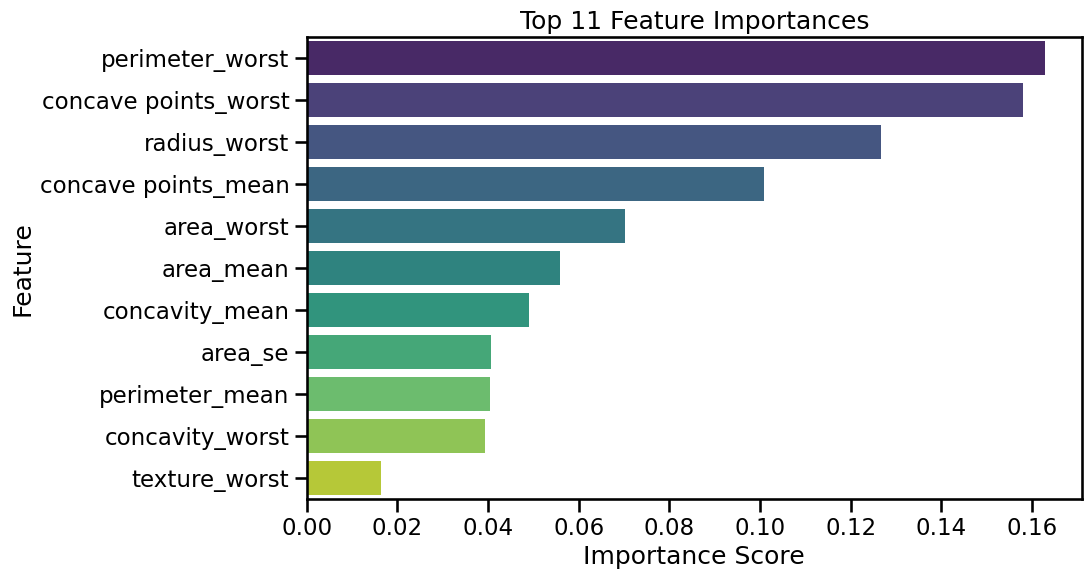

In [98]:
# Plot top 11 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 11 Feature Importances')
plt.show()

In [99]:
top_feat = top_features.index[:11].tolist()
X_top = X[top_feat]
X_top

,perimeter_worst,concave points_worst,radius_worst,concave points_mean,area_worst,area_mean,concavity_mean,area_se,perimeter_mean,concavity_worst,texture_worst
0,184.60,0.2654,25.38,0.14710,2019.0,1001.0,0.30010,5.039547,122.80,0.7119,17.33
1,158.80,0.1860,24.99,0.07017,1956.0,1326.0,0.08690,4.318554,132.90,0.2416,23.41
2,152.50,0.2430,23.57,0.12790,1709.0,1203.0,0.19740,4.554193,130.00,0.4504,25.53
3,98.87,0.2575,14.91,0.10520,567.7,386.1,0.24140,3.340385,77.58,0.6869,26.50
4,152.20,0.1625,22.54,0.10430,1575.0,1297.0,0.19800,4.558498,135.10,0.4000,16.67
...,...,...,...,...,...,...,...,...,...,...,...
562,128.70,0.2356,17.52,0.09429,915.0,716.9,0.25500,3.163363,103.40,1.1700,42.79
563,179.10,0.2542,24.29,0.14740,1819.0,1347.0,0.31740,4.785824,143.00,0.6599,29.41
564,166.10,0.2216,25.45,0.13890,2027.0,1479.0,0.24390,5.073297,142.00,0.4107,26.40
565,155.00,0.1628,23.69,0.09791,1731.0,1261.0,0.14400,4.605570,131.20,0.3215,38.25


In [100]:
y

0      1
1      1
2      1
3      1
4      1
      ..
562    1
563    1
564    1
565    1
566    1
Name: diagnosis, Length: 567, dtype: int64

In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, random_state=42)

In [102]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [103]:
# Initialize the Random Forest model with class weights
rf_model_1 = RandomForestClassifier(class_weight='balanced', random_state=42)

In [104]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
print("GridSearchCV Initialized")

GridSearchCV Initialized


In [105]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [106]:
# Best parameters and model
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [107]:
best_model = grid_search.best_estimator_

In [108]:
y_pred = best_model.predict(X_test)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        90
           1       0.96      0.88      0.92        52

    accuracy                           0.94       142
   macro avg       0.95      0.93      0.94       142
weighted avg       0.94      0.94      0.94       142



In [110]:
print(confusion_matrix(y_test, y_pred))

[[88  2]
 [ 6 46]]


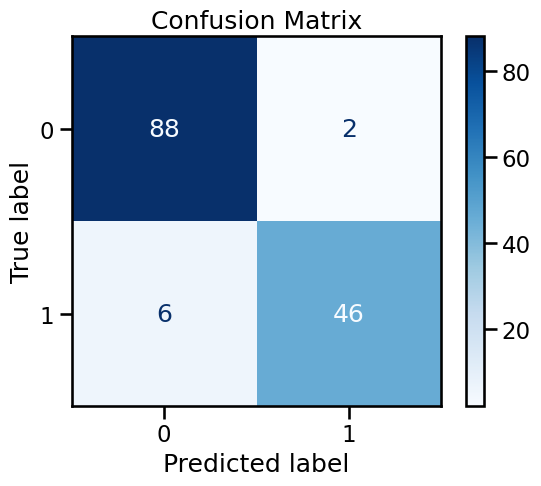

In [111]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [112]:
# Model Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9437


In [113]:
#save the optimized model
joblib.dump(best_model, '../Saved_Models/best_model.pkl')

['../Saved_Models/best_model.pkl']

In [114]:
#inspect my .pkl (pickle) file containing the model

# Load the model from the .pkl file
model = joblib.load('../Saved_Models/best_model.pkl')

In [115]:
# Check the model's parameters
print("Model Parameters:", model.get_params())

Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [116]:
# Review feature importances (if applicable)
if hasattr(model, 'feature_importances_'):
    print("Feature Importances:", model.feature_importances_)

Feature Importances: [0.13038462 0.1610983  0.13223232 0.2160126  0.10322268 0.02685852
 0.08882537 0.04191943 0.02936307 0.03626534 0.03381776]


In [117]:
# Review model classes
print("Classes:", model.classes_)

Classes: [0 1]


In [118]:
#Use some unseen data to make predictions and review the output.
top_feat = top_features.index[:11].tolist()
X_unseen = unseen_data.drop('diagnosis', axis=1)  # Features
X_unseen_top=X_unseen[top_feat]
y_unseen= unseen_data['diagnosis']  # Target

In [119]:
# Make a prediction
prediction = best_model.predict(X_unseen_top)
print("Prediction:", prediction)

Prediction: [1 0]


In [120]:
#compare with the unseen data
y_unseen

567    1
568    0
Name: diagnosis, dtype: int64

# Support Vector Machines (SVM)

A supervised learning algorithm primarily used for classification and regression tasks.

In [121]:
X = df_cleaned.drop('diagnosis', axis=1)  
y = df_cleaned['diagnosis']             
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [122]:
svm_scaler = StandardScaler()
svm_X_scaled = svm_scaler.fit_transform(X)
svm_X_train_scaled = svm_scaler.fit_transform(X_train)
svm_X_test_scaled = svm_scaler.transform(X_test)

In [123]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (567, 30)
Shape of y: (567,)


In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(svm_X_scaled)

In [125]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(C=1, kernel='linear', class_weight='balanced', random_state=42) # avoid imbalance model
model.fit(svm_X_train_scaled, y_train)

SVC(C=1, class_weight='balanced', kernel='linear', random_state=42)

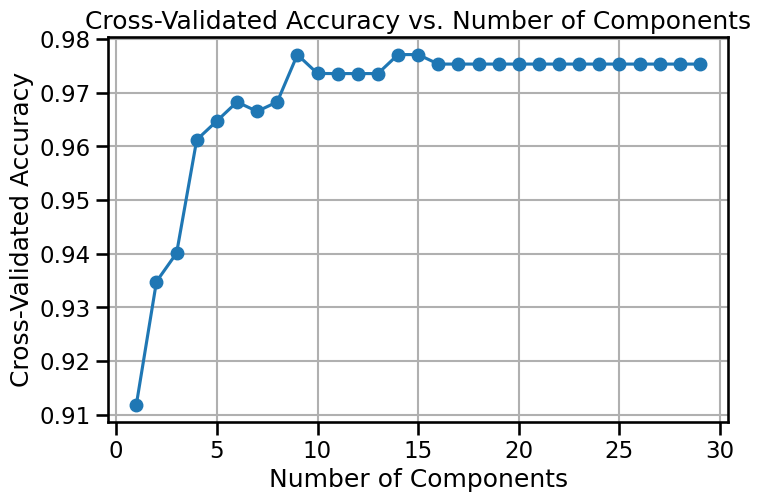

In [126]:
# test components numbers
n_components_range = range(1, 30)
scores = []

for n in n_components_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(svm_X_scaled)
    score = cross_val_score(SVC(), X_pca, y, cv=5) 
    scores.append(score.mean())

# plot Cross-Validated to get Accuracy point
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, scores, marker='o')
plt.title('Cross-Validated Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()

In [127]:
# feature importance within PCA
feature_loadings = pd.DataFrame(pca.components_, columns=X.columns)
importance = feature_loadings.abs().sum(axis=0).sort_values(ascending=False)
print("Feature Importance:\n", importance)

Feature Importance:
 concavity_worst            4.450152
concavity_se               4.257706
fractal_dimension_se       4.251578
compactness_se             4.241497
concave points_worst       4.226325
compactness_mean           4.181932
smoothness_worst           4.174896
fractal_dimension_worst    4.145885
concave points_mean        4.104660
concave points_se          4.097733
compactness_worst          4.040627
area_worst                 4.022803
smoothness_mean            4.018795
area_se                    4.015684
radius_se                  3.946007
fractal_dimension_mean     3.912788
symmetry_se                3.907211
symmetry_worst             3.906424
concavity_mean             3.881266
perimeter_se               3.763142
symmetry_mean              3.733755
smoothness_se              3.719864
radius_mean                3.707602
texture_se                 3.554626
area_mean                  3.543347
texture_mean               3.516307
radius_worst               3.513183
perimet

In [128]:
#pip install shap

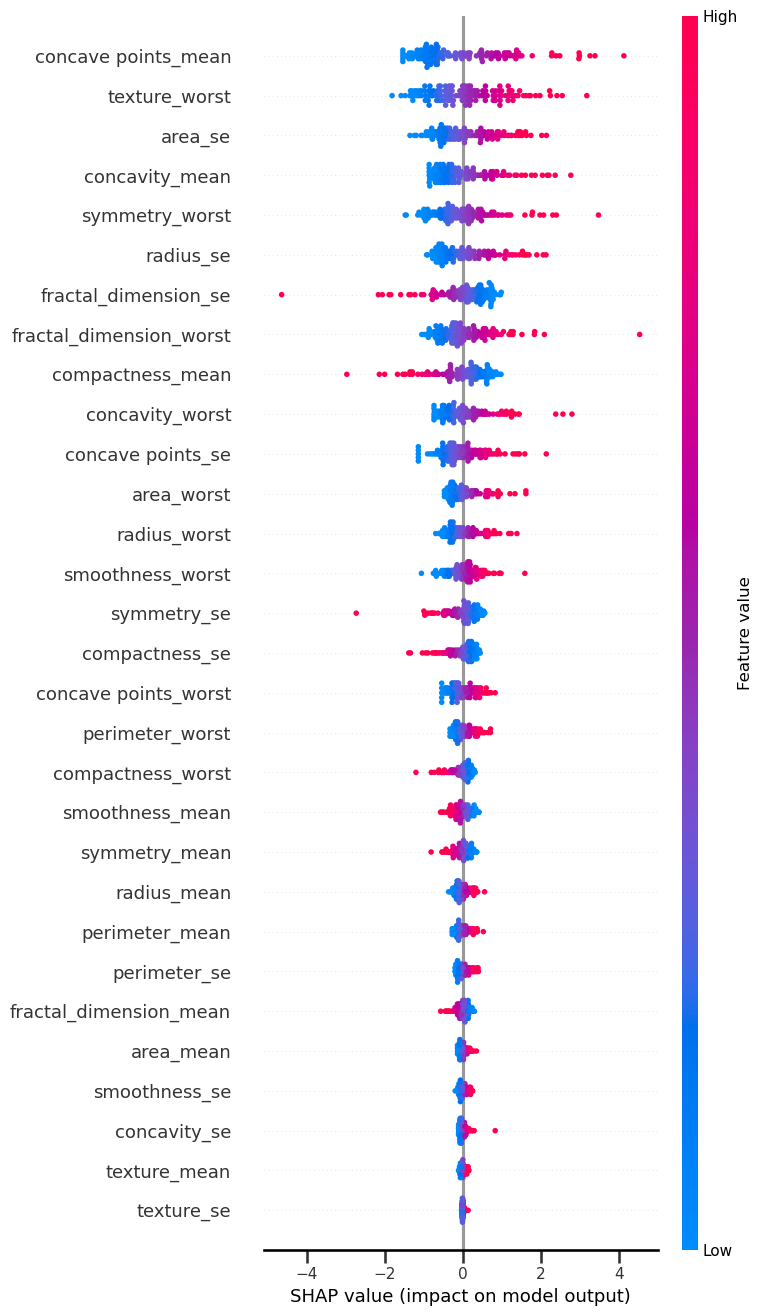

In [129]:
import shap

# Create the SHAP explainer using the scaled training data
explainer = shap.Explainer(model, svm_X_train_scaled)

# Calculate SHAP values for the scaled test data
shap_values = explainer(svm_X_test_scaled)

# Generate the summary plot with the correct feature names
shap.summary_plot(shap_values, svm_X_test_scaled, feature_names=X.columns,max_display=len(X.columns))

In [130]:
print(X.shape)
print(X.columns)

(567, 30)
Index(['area_mean', 'area_worst', 'compactness_mean', 'compactness_se',
       'compactness_worst', 'concave points_mean', 'concave points_se',
       'concave points_worst', 'concavity_mean', 'concavity_worst',
       'fractal_dimension_mean', 'fractal_dimension_worst', 'perimeter_mean',
       'perimeter_worst', 'radius_mean', 'radius_worst', 'smoothness_mean',
       'smoothness_se', 'smoothness_worst', 'symmetry_mean', 'symmetry_se',
       'symmetry_worst', 'texture_mean', 'texture_se', 'texture_worst',
       'area_se', 'concavity_se', 'perimeter_se', 'radius_se',
       'fractal_dimension_se'],
      dtype='object')


In [131]:
# Model Accuracy
print('Test Acc: %.3f' % model.score(svm_X_test_scaled, y_test))

Test Acc: 0.965


Confusion Matrix:
[[88  2]
 [ 3 49]]


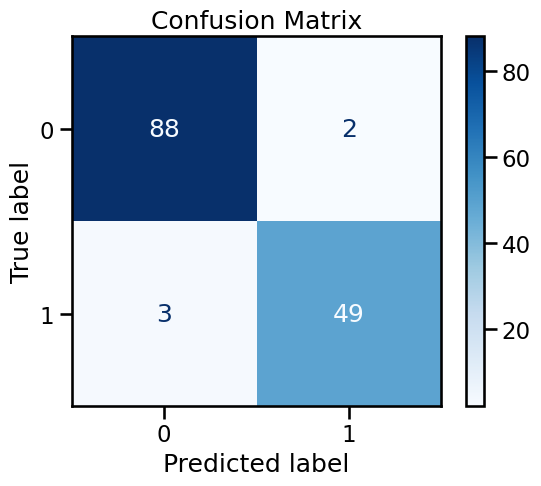

In [132]:
svm_predictions = model.predict(svm_X_test_scaled)
# Evaluate the model
print("Confusion Matrix:")
Confusion = confusion_matrix(y_test, svm_predictions)
print(Confusion)
# Create a heatmap to visualize the confusion matrix
disp_conf=ConfusionMatrixDisplay(confusion_matrix=Confusion)
disp_conf.plot(cmap='Blues')

plt.title("Confusion Matrix")
plt.show()

In [133]:
# Calculate the classification report

print(classification_report(y_test, svm_predictions,
                            target_names=['1','0']))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97        90
           0       0.96      0.94      0.95        52

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142



In [134]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto']  
}
# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5)
grid_search.fit(svm_X_train_scaled, y_train)

# Output the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score:  0.9788235294117648


In [135]:
# Get the best estimator
tunned_model = grid_search.best_estimator_

# Make predictions
y_pred = tunned_model.predict(svm_X_test_scaled)
svm_pred = y_pred

In [136]:
# Evaluate predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        90
           1       0.98      0.94      0.96        52

    accuracy                           0.97       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.97      0.97      0.97       142



In [137]:
# Evaluate the model
scores = cross_val_score(grid_search.best_estimator_, svm_X_train_scaled, y_train, cv=5)
print("Cross-validation scores: ", scores)
print("Mean CV score: ", scores.mean())

Cross-validation scores:  [0.98823529 0.95294118 1.         0.96470588 0.98823529]
Mean CV score:  0.9788235294117648


Confusion Matrix after Tunning:
[[89  1]
 [ 3 49]]


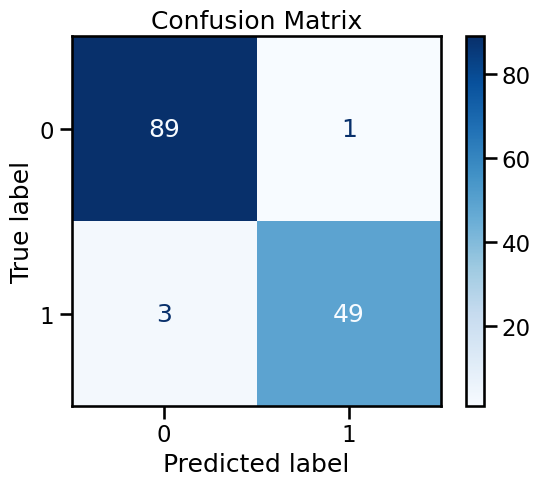

In [138]:
from sklearn.metrics import ConfusionMatrixDisplay
# Evaluate the model
print("Confusion Matrix after Tunning:")
Confusion_tun = confusion_matrix(y_test, y_pred)
print(Confusion_tun)

disp = ConfusionMatrixDisplay(confusion_matrix=Confusion_tun)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [139]:
# Initialize the SVC model with a linear kernel
svc = SVC(kernel='linear')
# Create the RFE selector, specifying the model and the number of features to select
selector = RFE(svc, n_features_to_select=5)  
# Fit the RFE model to the scaled training data
selector = selector.fit(svm_X_train_scaled, y_train)

# Transform the training and test datasets to select the relevant features
X_train_selected = selector.transform(svm_X_train_scaled)
X_test_selected = selector.transform(svm_X_test_scaled)

# Print the shape of the selected features
print(f"Selected features shape: {X_train_selected.shape}")

Selected features shape: (425, 5)


In [140]:
#Result is different to original notebook
selected_features_indices = selector.get_support(indices=True)
selected_features_names = [X.columns[i] for i in selected_features_indices]

print(f"Selected feature indices: {selected_features_indices}")
print(f"Selected feature names: {selected_features_names}")

Selected feature indices: [ 5 15 21 24 28]
Selected feature names: ['concave points_mean', 'radius_worst', 'symmetry_worst', 'texture_worst', 'radius_se']


In [141]:
# Fit the tuned model on the selected features
tunned_model.fit(X_train_selected, y_train)
# Make predictions on the test set with the selected features
y_pred_selected = tunned_model.predict(X_test_selected)

In [142]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_selected)
print(f"Selected Test Set Accuracy: {accuracy:.4f}")

Selected Test Set Accuracy: 0.9718


Classification Report after select feature:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        90
           1       0.98      0.94      0.96        52

    accuracy                           0.97       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.97      0.97      0.97       142

Confusion Matrix after select feature:
[[89  1]
 [ 3 49]]


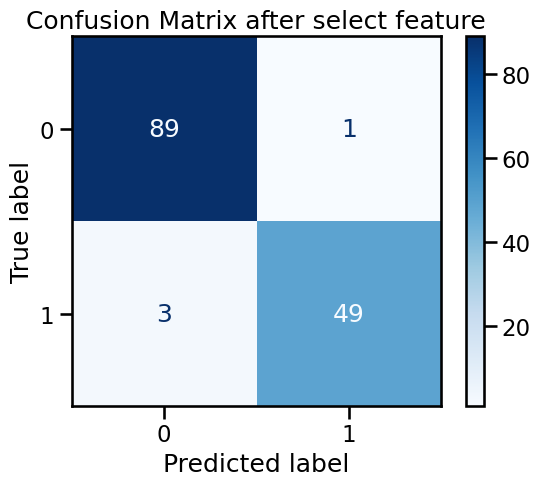

In [143]:
# Print classification report for detailed metrics
print("Classification Report after select feature:")
print(classification_report(y_test, y_pred_selected))

# Confusion Matrix
cm_select = confusion_matrix(y_test, y_pred_selected)
print("Confusion Matrix after select feature:")
print(cm_select)

disp_select = ConfusionMatrixDisplay(confusion_matrix=cm_select)
disp_select.plot(cmap='Blues')
plt.title('Confusion Matrix after select feature')
plt.show()

In [144]:
joblib.dump(tunned_model, '../Saved_Models/svm_forapp.pkl')

['../Saved_Models/svm_forapp.pkl']

In [145]:
joblib.dump(svm_scaler, '../Saved_Models/scaler_forapp.pkl')
joblib.dump(selector, '../Saved_Models/selector_forapp.pkl')

['../Saved_Models/selector_forapp.pkl']

# FINAL PREDICTION_pred))

In [168]:
from collections import Counter

# Ensure all predictions are numpy arrays
lr_pred = np.array(lr_pred, dtype=int)
svm_pred = np.array(svm_pred, dtype=int)
rf_pred = np.array(rf_pred, dtype=int)
kt_pred = np.array(kt_pred)

final_pred = np.array([])

# Loop through each sample in y_test to ensure consistent lengths
for i in range(len(y_test)):
    # Extract scalar from kt_pred array
    kt_pred_scalar = kt_pred[i][0] if isinstance(kt_pred[i], np.ndarray) else kt_pred[i]

    # Collect predictions from different models
    predictions = [lr_pred[i], svm_pred[i], rf_pred[i], int(kt_pred_scalar)]

    # Check the shape and value of each prediction
    print(f"Predictions at index {i}: {predictions}")

    # Find the most common prediction (mode)
    most_common_pred = Counter(predictions).most_common(1)[0][0]

    # Append the mode prediction to the final predictions array
    final_pred = np.append(final_pred, most_common_pred)


Predictions at index 0: [0, 0, 0, 0]
Predictions at index 1: [0, 0, 0, 0]
Predictions at index 2: [0, 0, 0, 0]
Predictions at index 3: [0, 0, 0, 0]
Predictions at index 4: [0, 0, 0, 0]
Predictions at index 5: [0, 0, 0, 0]
Predictions at index 6: [0, 0, 0, 0]
Predictions at index 7: [0, 0, 0, 0]
Predictions at index 8: [1, 1, 1, 1]
Predictions at index 9: [0, 0, 0, 0]
Predictions at index 10: [1, 1, 1, 1]
Predictions at index 11: [0, 0, 0, 0]
Predictions at index 12: [1, 0, 1, 0]
Predictions at index 13: [0, 0, 0, 0]
Predictions at index 14: [0, 0, 0, 0]
Predictions at index 15: [0, 0, 0, 0]
Predictions at index 16: [1, 1, 1, 0]
Predictions at index 17: [0, 0, 0, 0]
Predictions at index 18: [0, 0, 0, 0]
Predictions at index 19: [1, 1, 1, 0]
Predictions at index 20: [0, 0, 0, 0]
Predictions at index 21: [0, 0, 0, 0]
Predictions at index 22: [0, 0, 0, 0]
Predictions at index 23: [0, 0, 0, 0]
Predictions at index 24: [0, 0, 0, 0]
Predictions at index 25: [0, 0, 0, 0]
Predictions at index 2

Shape of final_pred: (142,)
Shape of y_test: (142,)
[[90  0]
 [ 2 50]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        90
           1       1.00      0.96      0.98        52

    accuracy                           0.99       142
   macro avg       0.99      0.98      0.98       142
weighted avg       0.99      0.99      0.99       142



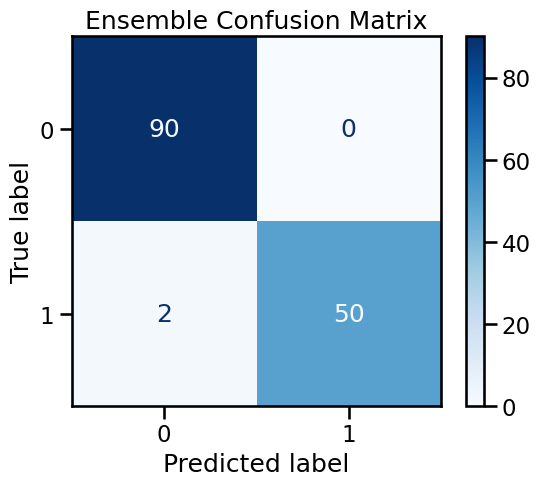

In [171]:
# Check the shape of the final predictions array
print(f"Shape of final_pred: {final_pred.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Generate the confusion matrix
cm_ensemble = confusion_matrix(y_test, final_pred)
print(cm_ensemble)

# Print the classification report
print(classification_report(y_test, final_pred))

# Print Heatmap Confusion Matrix
disp_select = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp_select.plot(cmap='Blues')
plt.title('Ensemble Confusion Matrix')
plt.show()